In [1]:
## for comet
#from comet_ml import Experiment

import numpy
from tqdm import tqdm
from collections import OrderedDict
from dataset import ptb
import sys
import os
import pickle
import random
import datetime

import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt

In [2]:
#device = 'cpu'
device = 'gpu'

np = numpy
if device == 'gpu':
    import cupy
    import cupyx
    np = cupy
print(f'Use {device}.')

Use gpu.


In [3]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def softmax(x, ndim=-1):
    x = x.astype('float64')
    if x.ndim == -1:
        ndim = len(x.shape) - 1
    c = x.max()
    exp_x = np.exp(x - c)
    sum_exp_x = np.sum(exp_x, axis=ndim)
    out = (exp_x.T / sum_exp_x).T
    return out.astype('f')

def cross_entropy_error(y, t, onehot=False):
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)
    batch_size = y.shape[0]
    if not onehot:
        out = -np.sum(np.log(y[np.arange(batch_size), t] + 1e-7)) / batch_size
    else:
        out = -np.sum(np.dot(t, np.log(y + 1e-7))) / batch_size
    return out

def numerical_diff(f, x, i):
    h = 1e-4
    h_vec = np.zeros_like(x)
    h_vec[i] = h
    return (f(x + h_vec) - f(x - h_vec)) / (2*h)

def numerical_diff2(f, x, i, j):
    h = 1e-4
    h_vec = np.zeros_like(x)
    h_vec[i, j] = h
    return (f(x + h_vec) - f(x - h_vec)) / (2*h)

def numerical_gradient(f, x):
    grad = np.zeros_like(x).astype(np.float128)
    n, m = x.shape
    for i in range(n):
        for j in range(m):
            grad[i, j] = numerical_diff2(f, x, i, j)
    return grad

def clip_grads(grads, max_norm):
    total_norm = 0
    for grad in grads:
        total_norm += np.sum(grad ** 2)
    total_norm = np.sqrt(total_norm)
    rate = max_norm / (total_norm + 1e-6)
    if rate < 1:
        for grad in grads:
            grad *= rate

def to_cpu(x):
    if type(x) == numpy.ndarray:
        return x
    return cupy.asnumpy(x)

def to_gpu(x):
    if type(x) == cupy.ndarray:
        return x
    return cupy.array(x)

def to_device(x, device=device):
    if device == 'gpu':
        return to_gpu(x)
    else:
        return to_cpu(x)

In [4]:
class Adam:
    def __init__(self, shape, alpha=0.001, beta1=0.9, beta2=0.999, epsilon=10**(-8)):
        self.alpha = alpha
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        self.m = np.zeros(shape)
        self.v = np.zeros(shape)
        self.t = 0

    def update(self, w, dw):
        self.t += 1
        self.m = (self.beta1 * self.m) + (1 - self.beta1) * dw
        self.v = (self.beta2 * self.v) + (1 - self.beta2) * dw**2
        mh = self.m / (1 - self.beta1 ** self.t)
        vh = self.v / (1 - self.beta2 ** self.t)
        w -= self.alpha * (mh / (np.sqrt(vh) + self.epsilon))

class AdamContainer:
    def __init__(self, layers, alpha=0.001, beta1=0.9, beta2=0.999, epsilon=10**(-8)):
        self.params = []
        for params in [layer.params for layer in layers]:
            for param in params:
                self.params.append(param)
        self.grads = []
        for grads in [layer.grads for layer in layers]:
            for grad in grads:
                self.grads.append(grad)
        self.adams = [Adam(param.shape, alpha, beta1, beta2, epsilon) for param in self.params]
    
    def update(self):
        for adam, param, grad in zip(self.adams, self.params, self.grads):
            adam.update(param, grad)

In [5]:
class BaseLayer:
    def __init__(self):
        self.params = None
        self.grads = None
        
    def to_cpu(self):
        for param in self.params:
            param = to_cpu(param)
        for grad in self.grads:
            grad = to_cpu(grad)
            
    def to_gpu(self):
        for param in self.params:
            param = to_gpu(param)
        for grad in self.grads:
            grad = to_gpu(grad)

class Affine(BaseLayer):
    def __init__(self, w, b):
        self.params = [w, b]
        self.grads = [np.zeros_like(w), np.zeros_like(b)]
    
    def forward(self, x):
        w, b = self.params
        self.x = x
        return np.dot(x, w) + b
    
    def backward(self, dout):
        w = self.params[0]
        dx = np.dot(dout, w.T)
        self.grads[0] = self.dw = np.dot(self.x.T, dout)
        self.grads[1] = self.db = np.sum(dout, axis=0)
        return dx

class TimeAffine(BaseLayer):
    def __init__(self, w, b):
        self.params = [w, b]
        self.grads = [np.zeros_like(w), np.zeros_like(b)]
        self.layers = None
        self.cache = None
        
    def forward(self, xs):
        w, b = self.params
        N, T, D = xs.shape
        D, V = w.shape
        
        out = np.empty((N, T, V), dtype='f')
        self.layers = []
        
        for t in range(T):
            layer = Affine(w, b)
            out[:,t,:] = layer.forward(xs[:,t,:])
            self.layers.append(layer)
        
        self.cache = (N, T, D, V)
        return out
    
    def backward(self, dout):
        N, T, D, V = self.cache
        
        out = np.empty((N, T, D), dtype='f')
        dw = np.empty((D, T, V), dtype='f')
        db = np.empty((T, V), dtype='f')
        for t in range(T):
            layer = self.layers[t]
            out[:,t,:] = layer.backward(dout[:,t,:])
            dw[:,t,:] = layer.dw
            db[t,:] = layer.db
        self.grads[0] = self.dw = dw.sum(axis=1)
        self.grads[1] = self.db = db.sum(axis=0)
        
        return out

class ReLU(BaseLayer):
    def __init__(self):
        self.params = []
        self.grads = []
    
    def forward(self, x):
        self.mask = (x <= 0)
        out = x.copy()
        out[self.mask] = 0
        return out
    
    def backward(self, dout):
        dout[self.mask] = 0
        return dout

class Sigmoid(BaseLayer):
    def __init__(self):
        self.params = []
        self.grads = []
        
    def forward(self, x):
        self.out = sigmoid(x)
        return self.out
    
    def backward(self, dout):
        dx = dout * self.out * (1 - self.out)
        return dx
    
class Softmax(BaseLayer):
    def __init__(self):
        self.params = []
        self.grads = []
        
    def forward(self, x):
        self.y = softmax(x)
        return self.y
    
    def backward(self, dout):
        dx = self.y * dout
        sumdx = np.sum(dx, axis=1, keepdims=True)
        dx -= self.y * sumdx
        return dx

class SoftmaxWithLoss(BaseLayer):
    def __init__(self):
        self.params = []
        self.grads = []
        
    def forward(self, x, t):
        self.t = t
        self.y = softmax(x)
        self.loss = cross_entropy_error(self.y, self.t)
        return self.loss
    
    def backward(self, dout=1, onehot=False):
        batch_size = self.t.shape[0]
        if not onehot:
            dx = self.y.copy()
            dx[np.arange(batch_size), self.t] -= 1
            dx *= dout
            dx = dx / batch_size
        else:
            dx = (self.y - self.t) / batch_size
        return dx

class TimeSoftmaxWithLoss(BaseLayer):
    def __init__(self):
        self.params = []
        self.grads = []
        self.layers = None
        self.cache = None
        
    def forward(self, xs, ts):
        N, T, V = xs.shape
        
        # if ts is one-hot vector
        if ts.ndim == 3:
            ts = ts.argmax(axis=2).reshape(N, T)
        
        ys = np.empty(T, dtype='f')
        self.layers = []
        
        for t in range(T):
            layer = SoftmaxWithLoss()
            ys[t] = layer.forward(xs[:,t,:], ts[:,t])
            self.layers.append(layer)
            
        loss = ys.sum() / T
        
        self.cache = (N, T, V)
        return loss
    
    def backward(self):
        N, T, V = self.cache
        dx = np.empty((N, T, V), dtype='f')
        for t in range(T):
            layer = self.layers[t]
            dx[:,t,:] = layer.backward()
        self.dx = dx / T
        
        return self.dx

class Dropout(BaseLayer):
    def __init__(self, ratio=0.5):
        self.params = []
        self.grads = []
        self.ratio = ratio
        self.mask = None
        self.train = True

    def forward(self, x):
        if self.train:
            self.mask = np.random.rand(*x.shape) > self.ratio
            self.mask = self.mask.astype('f') / (1.0 - self.ratio)
            return x * self.mask
        else:
            return x

    def backward(self, dout):
        return dout * self.mask

class Embedding(BaseLayer):
    def __init__(self, w):
        self.params = [w]
        self.grads = [np.zeros_like(w)]
        self.idx = None
        
    def forward(self, idx):
        w = self.params[0]
        self.idx = idx
        return w[idx]
    
    def backward(self, dout):
        if device == 'gpu':
            add_at = cupyx.scatter_add
        else:
            add_at = np.add.at
            
        dw = self.grads[0]
        dw[...] = 0
        add_at(dw, self.idx, dout)
        self.grads[0] = self.dw = dw
        return None

class TimeEmbedding(BaseLayer):
    def __init__(self, w):
        self.params = [w]
        self.grads = [np.zeros_like(w)]
        self.layers = None
        
    def forward(self, xs):
        w = self.params[0]
        N, T = xs.shape
        V, D = w.shape
        
        out = np.empty((N, T, D), dtype='f')
        self.layers = []
        
        for t in range(T):
            layer = Embedding(w)
            out[:,t,:] = layer.forward(xs[:,t])
            self.layers.append(layer)
            
        return out
    
    def backward(self, dout):
        N, T, D = dout.shape
        
        dw = 0
        for t in range(T):
            layer = self.layers[t]
            layer.backward(dout[:,t,:])
            dw += layer.dw
        self.grads[0] = self.dw = dw
        
        return None

class RNN(BaseLayer):
    def __init__(self, wx, wh, b):
        self.params = [wx, wh, b]
        self.grads = [np.zeros_like(wx), np.zeros_like(wh), np.zeros_like(b)]
    
    def forward(self, x, h_prev):
        wx, wh, b = self.params
        t = np.dot(h_prev, wh) + np.dot(x, wx) + b
        h_next = np.tanh(t)
        self.cache = (x, h_prev, h_next)
        return h_next
    
    def backward(self, dh_next):
        wx, wh, b = self.params
        x, h_prev, h_next = self.cache
        
        dt = dh_next * (1 - dh_next ** 2)
        db = np.sum(dt, axis=0)
        dwh = np.dot(h_prev.T, dt)
        dh_prev = np.dot(dt, wh.T)
        dwx = np.dot(x.T, dt)
        dx = np.dot(dt, wx.T)
        self.grads[0][...] = self.dwx = dwx
        self.grads[1][...] = self.dwh = dwh
        self.grads[2][...] = self.db = db
        
        return dx, dh_prev

class TimeRNN(BaseLayer):
    def __init__(self, wx, wh, b, stateful=False):
        self.params = [wx, wh, b]
        self.grads = [np.zeros_like(wx), np.zeros_like(wh), np.zeros_like(b)]
        self.layers = None
        self.h, self.dh = None, None
        self.stateful = stateful
        
    def set_state(self, h):
        self.h = h
        
    def reset_state(self):
        self.h = None
        
    def forward(self, xs):
        wx, wh, b = self.params
        N, T, D = xs.shape
        D, H = wx.shape
        
        self.layers = []
        hs = np.empty((N, T, H), dtype='f')
        if not self.stateful or self.h is None:
            self.h = np.zeros((N, H), dtype='f')
        
        for t in range(T):
            layer = RNN(*self.params)
            self.h = layer.forward(xs[:,t,:], self.h)
            hs[:,t,:] = self.h
            self.layers.append(layer)
        
        return hs
    
    def backward(self, dhs):
        wx, wh, b  = self.params
        N, T, H = dhs.shape
        D, H = wx.shape
        
        dxs = np.empty((N, T, D), dtype='f')
        dh = 0
        grads = [0, 0, 0]
        for t in reversed(range(T)):
            layer = self.layers[t]
            dx, dh = layer.backward(dhs[:,t,:] + dh)
            dxs[:,t,:] = dx
            for i, grad in enumerate(layer.grads):
                grads[i] += grad
        
        for i, grad in enumerate(grads):
            self.grads[i][...] = grad
        self.dwx = self.grads[0]
        self.dwh = self.grads[1]
        self.db = self.grads[2]
        self.dh = dh
        
        return dxs

class LSTM(BaseLayer):
    def __init__(self, wx, wh, b):
        self.params = [wx, wh, b]
        self.grads = [np.zeros_like(wx), np.zeros_like(wh), np.zeros_like(b)]
        self.cache = None
    
    def forward(self, x, h_prev, c_prev):
        wx, wh, b = self.params
        N, H = h_prev.shape
        
        A = np.dot(h_prev, wh) + np.dot(x, wx) + b
        
        f = A[:, :H]
        g = A[:, H:2*H]
        i = A[:, 2*H:3*H]
        o = A[:, 3*H:]
        
        f = sigmoid(f)
        g = np.tanh(g)
        i = sigmoid(i)
        o = sigmoid(o)
        
        c_next = f * c_prev + g * i
        h_next = o * np.tanh(c_next)
        
        self.cache = (x, h_prev, c_prev,i, f, g, o, c_next)
        return h_next, c_next
    
    def backward(self, dh_next, dc_next):
        wx, wh, b = self.params
        x, h_prev, c_prev, i, f, g, o, c_next = self.cache
        
        tanh_c_next = np.tanh(c_next)
        ds = dc_next + (dh_next * o) * (1 - tanh_c_next ** 2)
        
        dc_prev = ds * f
        di = ds * g
        df = ds * c_prev
        do = dh_next * tanh_c_next
        dg = ds * i
        
        di *= i * (1 - i)
        df *= f * (1 - f)
        do *= o * (1 - o)
        dg *= 1 - g ** 2
        
        dA = np.hstack((df, dg, di, do))
        
        dwh = np.dot(h_prev.T, dA)
        dh_prev = np.dot(dA, wh.T)
        dwx = np.dot(x.T, dA)
        dx = np.dot(dA, wx.T)
        db = dA.sum(axis=0)
        
        self.grads[0][...] = self.dwx = dwx
        self.grads[1][...] = self.dwh = dwh
        self.grads[2][...] = self.db = db
        
        return dx, dh_prev, dc_prev

class TimeLSTM(BaseLayer):
    def __init__(self, wx, wh, b, stateful=False):
        self.params = [wx, wh, b]
        self.grads = [np.zeros_like(wx), np.zeros_like(wh), np.zeros_like(b)]
        self.layers = None
        self.h, self.dh, self.c = None, None, None
        self.stateful = stateful
        
    def set_state(self, h, c=None):
        self.h, self.c = h, c
        
    def reset_state(self):
        self.h, self.c = None, None
        
    def forward(self, xs):
        wx, wh, b = self.params
        N, T, D = xs.shape
        H = wh.shape[0]
        
        self.layers = []
        hs = np.empty((N, T, H), dtype='f')
        if not self.stateful or self.h is None:
            self.h = np.zeros((N, H), dtype='f')
        if not self.stateful or self.c is None:
            self.c = np.zeros((N, H), dtype='f')
        
        for t in range(T):
            layer = LSTM(*self.params)
            self.h, self.c = layer.forward(xs[:,t,:], self.h, self.c)
            hs[:,t,:] = self.h
            self.layers.append(layer)
        
        return hs
    
    def backward(self, dhs):
        wx, wh, b  = self.params
        N, T, H = dhs.shape
        D = wx.shape[0]
        
        dxs = np.empty((N, T, D), dtype='f')
        dh, dc = 0, 0
        grads = [0, 0, 0]
        for t in reversed(range(T)):
            layer = self.layers[t]
            dx, dh, dc = layer.backward(dhs[:,t,:] + dh, dc)
            dxs[:,t,:] = dx
            for i, grad in enumerate(layer.grads):
                grads[i] += grad
        
        for i, grad in enumerate(grads):
            self.grads[i][...] = grad
        self.dwx = self.grads[0]
        self.dwh = self.grads[1]
        self.db = self.grads[2]
        self.dh = dh
        
        return dxs

class BaseNetwork:
    def __init__(self):
        self.layers = None
        self.lastLayer = None
        self.adam = None
        
    def train(self, x, t):
        # forward
        loss = self.loss(x, t)
        
        # backward
        dout = self.lastLayer.backward()
        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)
        
        self.update()
            
        return loss
    
    def update(self):
        for grads in [layer.grads for layer in self.layers.values()]:
            clip_grads(grads, self.max_grad)
        self.adam.update()
    
    def save(self, state_file_name = 'network.state.pkl'):
        params = self.adam.params.copy()
        for i, param in enumerate(params):
            params[i] = to_cpu(params[i])
            
        with open(state_file_name, 'wb') as f:
            pickle.dump(params, f)
            print(f'Saved: {state_file_name}')
            
    def load(self, state_file_name = 'network.state.pkl'):
        if os.path.exists(state_file_name):
            with open(state_file_name, 'rb') as f:
                params = pickle.load(f)
                for i, param in enumerate(params):
                    self.adam.params[i][:] = to_device(param, device)
                print(f'Loaded: {state_file_name}')

In [6]:
class Encoder(BaseLayer):
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn
        
        embed_w = (rn(V, D) / 100).astype('f')
        lstm_wx = (rn(D, 4 * H) / np.sqrt(D)).astype('f')
        lstm_wh = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_b = np.zeros(4 * H).astype('f')
        
        self.layers = OrderedDict()
        self.layers['Embedding'] = TimeEmbedding(embed_w)
        self.layers['LSTM'] = TimeLSTM(lstm_wx, lstm_wh, lstm_b, stateful=False)
        
        self.params = []
        for params in [layer.params for layer in self.layers.values()]:
            for param in params:
                self.params.append(param)
        self.grads = []
        for grads in [layer.grads for layer in self.layers.values()]:
            for grad in grads:
                self.grads.append(grad)
        self.hs = None
        
    def forward(self, xs):
        for layer in self.layers.values():
            xs = layer.forward(xs)
        self.hs = xs
        return xs[:,-1,:]
    
    def backward(self, dh):
        dhs = np.zeros_like(self.hs)
        dhs[:,-1,:] = dh
        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dhs = layer.backward(dhs)
        return dhs

In [7]:
class WeightSum(BaseLayer):
    def __init__(self):
        self.params = []
        self.grads = []
        self.cache = None
        
    def forward(self, hs, a):
        N, T, H = hs.shape
        
        ar = a.reshape(N, T, 1) #.repeat(H, axis=2)
        t = hs * ar
        c = np.sum(t, axis=1)
        
        self.cache = (hs, ar)
        return c
    
    def backward(self, dc):
        hs, ar = self.cache
        N, T, H = hs.shape
        
        dt = dc.reshape(N, 1, H).repeat(T, axis=1)
        dar = dt * hs
        dhs = dt * ar
        da = np.sum(dar, axis=2)
        
        return dhs, da

class AttentionWeight(BaseLayer):
    def __init__(self):
        self.params = []
        self.grads = []
        self.softmax = Softmax()
        self.cache = None
    
    def forward(self, hs, h):
        N, T, H = hs.shape
        
        hr = h.reshape(N, 1, H) #.repeat(T, axis=1)
        t = hs * hr
        s = np.sum(t, axis=2)
        a = self.softmax.forward(s)
        
        self.cache = (hs, hr)
        return a
        
    def backward(self, da):
        hs, hr = self.cache
        N, T, H = hs.shape
        
        ds = self.softmax.backward(da)
        dt = ds.reshape(N, T, 1).repeat(H, axis=2)
        dhs = dt * hr
        dhr = dt * hs
        dh = np.sum(dhr, axis=1)
        
        return dhs, dh

class Attention(BaseLayer):
    def __init__(self):
        self.params = []
        self.grads = []
        self.attention_weight_layer = AttentionWeight()
        self.weight_sum_layer = WeightSum()
        self.attention_weight = None
    
    def forward(self, hs, h):
        a = self.attention_weight_layer.forward(hs, h)
        out = self.weight_sum_layer.forward(hs, a)
        self.attention_weight = a
        return out
    
    def backward(self, dout):
        dhs0, da = self.weight_sum_layer.backward(dout)
        dhs1, dh = self.attention_weight_layer.backward(da)
        dhs = dhs0 + dhs1
        return dhs, dh

class TimeAttention(BaseLayer):
    def __init__(self):
        self.params = []
        self.grads = []
        self.layers = None
        self.attention_weights = None
        
    def forward(self, hs_enc, hs_dec):
        N, T, H = hs_dec.shape
        out = np.empty_like(hs_dec)
        self.layers = []
        self.attention_weights = []
        
        for t in range(T):
            layer = Attention()
            out[:, t, :] = layer.forward(hs_enc, hs_dec[:, t, :])
            self.layers.append(layer)
            self.attention_weights.append(layer.attention_weight)
            
        return out
    
    def backward(self, dout):
        N, T, H = dout.shape
        dhs_enc = 0
        dhs_dec = np.empty_like(dout)
        
        for t in range(T):
            layer = self.layers[t]
            dhs, dh = layer.backward(dout[:, t, :])
            dhs_enc += dhs
            dhs_dec[:, t, :] = dh
        
        return dhs_enc, dhs_dec

class AttentionEncoder(Encoder):
    def forward(self, xs):
        for layer in self.layers.values():
            xs = layer.forward(xs)
        return xs
    
    def backward(self, dhs):
        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dhs = layer.backward(dhs)
        return dhs

class AttentionDecoder(BaseLayer):
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn
        
        embed_w = (rn(V, D) / 100).astype('f')
        lstm_wx = (rn(D, 4 * H) / np.sqrt(D)).astype('f')
        lstm_wh = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_b = np.zeros(4 * H).astype('f')
        
        affine_w = (rn(2 * H, V) / np.sqrt(2 * H)).astype('f')
        affine_b = np.zeros(V).astype('f')
        
        self.layers = OrderedDict()
        self.layers['Embedding'] = TimeEmbedding(embed_w)
        self.layers['LSTM'] = TimeLSTM(lstm_wx, lstm_wh, lstm_b, stateful=True)
        self.layers['Attention'] = TimeAttention()
        self.layers['Affine'] = TimeAffine(affine_w, affine_b)
        
        self.params = []
        for params in [layer.params for layer in self.layers.values()]:
            for param in params:
                self.params.append(param)
        self.grads = []
        for grads in [layer.grads for layer in self.layers.values()]:
            for grad in grads:
                self.grads.append(grad)
        
    def forward(self, xs, enc_hs):
        h = enc_hs[:, -1]
        self.layers['LSTM'].set_state(h)
        
        out = self.layers['Embedding'].forward(xs)
        dec_hs = self.layers['LSTM'].forward(out)
        c = self.layers['Attention'].forward(enc_hs, dec_hs)
        out = np.concatenate((c, dec_hs), axis=2)
        score = self.layers['Affine'].forward(out)
        return score
    
    def backward(self, dscore):
        dout = self.layers['Affine'].backward(dscore)
        N, T, H2 = dout.shape
        H = H2 // 2
        dc, ddec_hs0 = dout[:, :, :H], dout[: ,: ,H:]
        denc_hs, ddec_hs1 = self.layers['Attention'].backward(dc)
        ddec_hs = ddec_hs0 + ddec_hs1
        dout = self.layers['LSTM'].backward(ddec_hs)
        denc_hs[:, -1] += self.layers['LSTM'].dh
        self.layers['Embedding'].backward(dout)

        return denc_hs

    def generate(self, enc_hs, start_id, sample_size):
        sampled = []
        sample_id = start_id
        h = enc_hs[:,  -1]
        self.layers['LSTM'].set_state(h)

        for _ in range(sample_size):
            x = np.array(sample_id).reshape(1, 1)
            out = self.layers['Embedding'].forward(x)
            dec_hs = self.layers['LSTM'].forward(out)
            c = self.layers['Attention'].forward(enc_hs, dec_hs)
            out = np.concatenate((c, dec_hs), axis=2)
            score = self.layers['Affine'].forward(out)

            sample_id = np.argmax(score.flatten())
            sampled.append(sample_id)

        return np.array(sampled)

class AttentionSeq2SeqNetwork(BaseNetwork):
    def __init__(self, vocab_size, wordvec_size, hidden_size, max_grad=5.0):
        V, D, H = vocab_size, wordvec_size, hidden_size
        self.max_grad = max_grad
        self.layers = OrderedDict()
        self.layers['Encoder'] = AttentionEncoder(V, D, H)
        self.layers['Decoder'] = AttentionDecoder(V, D, H)
        self.lastLayer = TimeSoftmaxWithLoss()
        self.adam = AdamContainer(list(self.layers.values()))
        
    def generate(self, xs, start_id, sample_size):
        h = self.layers['Encoder'].forward(xs)
        sampled = self.layers['Decoder'].generate(h, start_id, sample_size)
        return sampled
        
    def loss(self, xs, ts):
        decoder_xs, decoder_ts = ts[:, :-1], ts[:, 1:]
        h = self.layers['Encoder'].forward(xs)
        score = self.layers['Decoder'].forward(decoder_xs, h)
        loss = self.lastLayer.forward(score, decoder_ts)
        return loss

In [8]:
def generate_date_question(max_daydelta=10000):
    today = datetime.date.today()
    date = today + datetime.timedelta(days=random.randint(-max_daydelta, max_daydelta))
    question = date.strftime('%Y %B %d %A')
    correct = '=' + date.strftime('%Y-%m-%d')
    question = question.ljust(29)
    correct = correct.ljust(1+10+1)
    return question, correct

def make_date_questions(question_num):
    questions =  []
    corrects = []
    char_to_id = {}
    
    index = 0
    for number in range(10):
        char_to_id[f'{number}'] = index
        index += 1
    for alphabet in range(26):
        char_to_id[f'{chr(ord("a") + alphabet)}'] = index
        char_to_id[f'{chr(ord("A") + alphabet)}'] = index + 1
        index += 2
    char_to_id['='] = index
    char_to_id['-'] = index + 1
    char_to_id[' '] = index + 2
    
    for _ in range(question_num):
        q, c = generate_date_question()
        q = [char_to_id[s] for s in q]
        c = [char_to_id[s] for s in c]
        questions.append(q)
        corrects.append(c)
    questions = np.array(questions)
    corrects = np.array(corrects)
    
    id_to_char = dict(zip(char_to_id.values(), char_to_id.keys()))
    
    return questions[:, ::-1], corrects, char_to_id, id_to_char

In [9]:
class Program3:
    def __init__(self):
        sample_size = 50000
        self.questions, self.corrects, self.char_to_id, self.id_to_char = make_date_questions(sample_size)
        self.params = OrderedDict({'vocab_size': len(self.char_to_id), 'wordvec_size': 16, 'hidden_size': 256,
                                   'max_grad': 5.0, 'max_epoch': 80, 'sample_size': sample_size, 'batch_size': 128})
        self.net = AttentionSeq2SeqNetwork(self.params['vocab_size'], self.params['wordvec_size'], self.params['hidden_size'], self.params['max_grad'])
        self.losses = []
        
    def fit(self, x, t, batch_size):
        data_size = len(x)
        max_iters = data_size // batch_size
        
        for iters in tqdm(range(max_iters)):
            batch_x = x[iters*batch_size:(iters+1)*batch_size]
            batch_t = t[iters*batch_size:(iters+1)*batch_size]

            loss = self.net.train(batch_x, batch_t)
            self.losses.append(loss.tolist())
            
        return loss
    
    def visualize(self, attention_map, row_labels, column_labels):
        fig, ax = plt.subplots()
        ax.pcolor(attention_map, cmap=plt.cm.Greys_r, vmin=0.0, vmax=1.0)

        ax.patch.set_facecolor('black')
        ax.set_yticks(np.arange(attention_map.shape[0])+0.5, minor=False)
        ax.set_xticks(np.arange(attention_map.shape[1])+0.5, minor=False)
        ax.invert_yaxis()
        ax.set_xticklabels(row_labels, minor=False)
        ax.set_yticklabels(column_labels, minor=False)

        plt.savefig('figure.png')
        plt.clf()
        plt.close()
        print('Saved: figure.png')
    
    def save_figure(self):
        global np, device
        device_changed = False
        
        temp_file_name = 'temp.state.pkl'
        self.net.save(temp_file_name)
        
        if device == 'gpu':
            print('Change to cpu.')
            device = 'cpu'
            np = numpy
            device_changed = True
        
        _program = Program3()
        _program.net.load(temp_file_name)
        
        for i in tqdm(range(len(_program.questions))):
            question = to_cpu(_program.questions[[i]])
            correct = to_cpu(_program.corrects[[i]])
            answer = _program.net.generate(question, start_id=self.char_to_id['='], sample_size=10)
            _program.net.loss(question, correct)
            question = [_program.id_to_char[x] for x in question[0, ::-1]]
            correct = [_program.id_to_char[x] for x in correct[0, 1:-1]]
            answer = [_program.id_to_char[x] for x in answer]
            if answer != correct:
                  continue
            
            attention_map = np.array(_program.net.layers['Decoder'].layers['Attention'].attention_weights)
            attention_map = attention_map[:, 0, :].reshape(attention_map.shape[0], attention_map.shape[2])
            attention_map = attention_map[:-1, ::-1]
            _program.visualize(attention_map, question, correct)
            break
                  
        if device_changed:
            print('Change to gpu.')
            device = 'gpu'
            np = cupy
        
        os.remove(temp_file_name)
        
    def __call__(self):
        ## for comet
        #experiment = Experiment()
        #experiment.log_parameters(self.params)
        
        for key in self.params.keys() :
            print(f'{key}: {self.params[key]}')
        vocab_size, wordvec_size, hidden_size, max_grad, max_epoch, sample_size, batch_size = self.params.values()

        self.net.load()
        
        for epoch in range(max_epoch):
            loss = self.fit(self.questions, self.corrects, batch_size)
            
            correct_num = 0
            test_num = 3
            for _ in range(test_num):
                questions, corrects, _, _ = make_date_questions(1)
                answer = self.net.generate(questions, start_id=self.char_to_id['='], sample_size=10)
                question = ''.join([self.id_to_char[x] for x in to_cpu(questions[0, ::-1])])
                correct = ''.join([self.id_to_char[x] for x in to_cpu(corrects[0, 1:-1])])
                answer = ''.join([self.id_to_char[x] for x in to_cpu(answer)])
                is_correct = True if answer == correct else False
                correct_num += 1 if is_correct else 0
                print(f'{"○" if is_correct else "×"} {question} = {answer} [{correct}]')
            print(f'[{epoch}] Corrects {correct_num} / {test_num}\tloss: {loss}')
            
            ## for comet
            #experiment.log_metric('loss', loss, step=epoch)
        
        self.net.save()
        self.exam()
        self.save_figure()

        ## for comet
        #experiment.end()
    
    def exam(self, question_num=100):
        correct_num = 0
        for _ in range(question_num):
            questions, corrects, _, _ = make_date_questions(1)
            answer = self.net.generate(questions, start_id=self.char_to_id['='], sample_size=10)
            question = ''.join([self.id_to_char[x] for x in to_cpu(questions[0, ::-1])])
            correct = ''.join([self.id_to_char[x] for x in to_cpu(corrects[0, 1:-1])])
            answer = ''.join([self.id_to_char[x] for x in to_cpu(answer)])
            is_correct = True if answer == correct else False
            correct_num += 1 if is_correct else 0
            print(f'{"○" if is_correct else "×"} {question} = {answer} [{correct}]')
        print(f'Score: {correct_num} / {question_num}\tAccuracy: {(correct_num / question_num)}')

In [10]:
program = Program3()
if __name__ == '__main__':
    program()

vocab_size: 65
wordvec_size: 16
hidden_size: 256
max_grad: 5.0
max_epoch: 80
sample_size: 50000
batch_size: 128


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:23<00:00, 16.63it/s]


× 2008 March 13 Thursday        = 2019-01-11 [2008-03-13]
× 2044 June 05 Sunday           = 2019-01-11 [2044-06-05]
× 2044 January 13 Wednesday     = 2019-01-11 [2044-01-13]
[0] Corrects 0 / 3	loss: 1.0557314157485962


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:23<00:00, 16.34it/s]


× 2012 July 18 Wednesday        = 2010-01-11 [2012-07-18]
× 2038 March 24 Wednesday       = 2010-01-11 [2038-03-24]
× 2016 February 10 Wednesday    = 2010-01-11 [2016-02-10]
[1] Corrects 0 / 3	loss: 1.0305585861206055


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:24<00:00, 15.94it/s]


× 2015 April 29 Wednesday       = 2010-01-11 [2015-04-29]
× 2005 September 29 Thursday    = 2010-01-11 [2005-09-29]
× 2027 June 21 Monday           = 2010-01-11 [2027-06-21]
[2] Corrects 0 / 3	loss: 1.0139365196228027


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:24<00:00, 15.64it/s]


× 2002 November 16 Saturday     = 2019-01-11 [2002-11-16]
× 1997 March 13 Thursday        = 2019-01-11 [1997-03-13]
× 2022 August 07 Sunday         = 2019-01-11 [2022-08-07]
[3] Corrects 0 / 3	loss: 1.0188044309616089


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:25<00:00, 15.18it/s]


× 2020 November 20 Friday       = 2000-01-11 [2020-11-20]
× 2002 March 30 Saturday        = 2000-01-11 [2002-03-30]
× 2006 March 10 Friday          = 2000-01-11 [2006-03-10]
[4] Corrects 0 / 3	loss: 1.0016144514083862


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:25<00:00, 15.07it/s]


× 2008 November 06 Thursday     = 2010-01-11 [2008-11-06]
× 2020 June 19 Friday           = 2010-01-11 [2020-06-19]
× 2040 September 05 Wednesday   = 2010-01-11 [2040-09-05]
[5] Corrects 0 / 3	loss: 0.9871804714202881


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:25<00:00, 15.01it/s]


× 2021 March 06 Saturday        = 2010-01-11 [2021-03-06]
× 1998 February 10 Tuesday      = 2010-01-11 [1998-02-10]
× 2003 January 07 Tuesday       = 2010-01-11 [2003-01-07]
[6] Corrects 0 / 3	loss: 0.9825921654701233


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:26<00:00, 14.80it/s]


× 2045 May 24 Wednesday         = 2000-01-11 [2045-05-24]
× 2004 December 17 Friday       = 2000-01-11 [2004-12-17]
× 2035 November 17 Saturday     = 2000-01-11 [2035-11-17]
[7] Corrects 0 / 3	loss: 0.9801673889160156


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:26<00:00, 14.73it/s]


× 2019 December 31 Tuesday      = 2010-01-11 [2019-12-31]
× 2000 September 23 Saturday    = 2010-01-11 [2000-09-23]
× 2006 January 30 Monday        = 2010-01-11 [2006-01-30]
[8] Corrects 0 / 3	loss: 0.9780271649360657


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:27<00:00, 14.42it/s]


× 2000 April 13 Thursday        = 2000-01-11 [2000-04-13]
× 2042 February 25 Tuesday      = 2000-01-11 [2042-02-25]
× 2039 July 13 Wednesday        = 2000-01-11 [2039-07-13]
[9] Corrects 0 / 3	loss: 0.9763128757476807


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:26<00:00, 14.49it/s]


× 2020 February 19 Wednesday    = 2010-01-11 [2020-02-19]
× 2020 July 04 Saturday         = 2000-01-11 [2020-07-04]
× 2018 December 19 Wednesday    = 2010-01-11 [2018-12-19]
[10] Corrects 0 / 3	loss: 0.9734077453613281


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:27<00:00, 14.41it/s]


× 2009 September 14 Monday      = 2000-01-11 [2009-09-14]
× 1999 May 29 Saturday          = 2000-01-11 [1999-05-29]
× 2022 December 30 Friday       = 2000-01-11 [2022-12-30]
[11] Corrects 0 / 3	loss: 0.9652674198150635


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:26<00:00, 14.55it/s]


× 2023 January 31 Tuesday       = 2000-01-21 [2023-01-31]
× 2026 June 03 Wednesday        = 2000-01-21 [2026-06-03]
× 2021 June 29 Tuesday          = 2000-01-21 [2021-06-29]
[12] Corrects 0 / 3	loss: 0.959685742855072


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:26<00:00, 14.65it/s]


× 2040 November 25 Sunday       = 2010-01-11 [2040-11-25]
× 2017 November 07 Tuesday      = 2010-01-11 [2017-11-07]
× 2045 May 12 Friday            = 2010-08-11 [2045-05-12]
[13] Corrects 0 / 3	loss: 0.9518120288848877


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:26<00:00, 14.57it/s]


× 2030 November 15 Friday       = 2000-01-21 [2030-11-15]
× 2000 January 25 Tuesday       = 2000-01-21 [2000-01-25]
× 2021 July 24 Saturday         = 2010-08-11 [2021-07-24]
[14] Corrects 0 / 3	loss: 0.9403224587440491


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:26<00:00, 14.52it/s]


× 2038 July 27 Tuesday          = 2000-07-11 [2038-07-27]
× 2030 December 29 Sunday       = 2000-01-11 [2030-12-29]
× 1997 October 16 Thursday      = 2010-01-11 [1997-10-16]
[15] Corrects 0 / 3	loss: 0.9332176446914673


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:26<00:00, 14.86it/s]


× 2010 May 12 Wednesday         = 2010-07-11 [2010-05-12]
× 2043 April 15 Wednesday       = 2010-09-11 [2043-04-15]
× 2006 August 31 Thursday       = 2010-01-21 [2006-08-31]
[16] Corrects 0 / 3	loss: 0.9233273863792419


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:26<00:00, 14.79it/s]


× 2037 February 14 Saturday     = 2010-01-21 [2037-02-14]
× 2017 December 29 Friday       = 2010-01-23 [2017-12-29]
× 2039 November 15 Tuesday      = 2010-01-13 [2039-11-15]
[17] Corrects 0 / 3	loss: 0.9066560864448547


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:25<00:00, 15.01it/s]


× 2008 October 02 Thursday      = 2010-01-11 [2008-10-02]
× 2047 December 26 Thursday     = 2010-01-19 [2047-12-26]
× 2045 August 02 Wednesday      = 2010-09-11 [2045-08-02]
[18] Corrects 0 / 3	loss: 0.8939329385757446


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:25<00:00, 15.00it/s]


× 2030 September 14 Saturday    = 2010-09-10 [2030-09-14]
× 2003 September 07 Sunday      = 2010-09-29 [2003-09-07]
× 2051 March 21 Tuesday         = 2010-05-11 [2051-03-21]
[19] Corrects 0 / 3	loss: 0.8844974040985107


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:26<00:00, 14.92it/s]


× 2017 May 30 Tuesday           = 2010-05-16 [2017-05-30]
× 2008 November 05 Wednesday    = 2010-01-29 [2008-11-05]
× 2018 August 28 Tuesday        = 2010-07-17 [2018-08-28]
[20] Corrects 0 / 3	loss: 0.8778515458106995


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:26<00:00, 14.87it/s]


× 2012 August 18 Saturday       = 2010-09-13 [2012-08-18]
× 1998 August 04 Tuesday        = 2010-07-10 [1998-08-04]
× 2026 September 17 Thursday    = 2010-09-19 [2026-09-17]
[21] Corrects 0 / 3	loss: 0.8617922067642212


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:26<00:00, 14.95it/s]


× 2012 September 26 Wednesday   = 2019-09-10 [2012-09-26]
× 2030 April 19 Friday          = 2019-05-17 [2030-04-19]
× 2036 February 12 Tuesday      = 2019-01-11 [2036-02-12]
[22] Corrects 0 / 3	loss: 0.8968986868858337


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:26<00:00, 14.90it/s]


× 2008 June 28 Saturday         = 2000-05-19 [2008-06-28]
× 2051 May 12 Friday            = 2010-05-11 [2051-05-12]
× 2027 October 20 Wednesday     = 2010-01-11 [2027-10-20]
[23] Corrects 0 / 3	loss: 0.8729116320610046


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:26<00:00, 14.76it/s]


× 2002 September 28 Saturday    = 2000-09-29 [2002-09-28]
× 2002 August 20 Tuesday        = 2000-08-20 [2002-08-20]
× 2023 April 10 Monday          = 2000-05-23 [2023-04-10]
[24] Corrects 0 / 3	loss: 0.8607420325279236


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:26<00:00, 14.97it/s]


× 1997 January 19 Sunday        = 2000-01-17 [1997-01-19]
× 2036 May 06 Tuesday           = 2000-05-06 [2036-05-06]
× 2040 May 29 Tuesday           = 2000-05-07 [2040-05-29]
[25] Corrects 0 / 3	loss: 0.8527868390083313


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:26<00:00, 14.83it/s]


× 2002 August 30 Friday         = 2010-05-28 [2002-08-30]
× 2003 April 14 Monday          = 2010-05-28 [2003-04-14]
× 2040 June 04 Monday           = 2019-05-26 [2040-06-04]
[26] Corrects 0 / 3	loss: 0.8783330917358398


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:26<00:00, 14.86it/s]


× 2022 May 10 Tuesday           = 2010-05-10 [2022-05-10]
× 2014 August 02 Saturday       = 2010-08-11 [2014-08-02]
× 2025 May 28 Wednesday         = 2010-03-19 [2025-05-28]
[27] Corrects 0 / 3	loss: 0.8575801849365234


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:26<00:00, 14.82it/s]


× 2019 October 03 Thursday      = 2010-01-13 [2019-10-03]
× 2005 July 26 Tuesday          = 2000-05-20 [2005-07-26]
× 2036 October 12 Sunday        = 2010-01-11 [2036-10-12]
[28] Corrects 0 / 3	loss: 0.8388051986694336


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:25<00:00, 15.02it/s]


× 2028 October 28 Saturday      = 2020-11-28 [2028-10-28]
× 2037 December 09 Wednesday    = 2020-11-28 [2037-12-09]
× 2001 January 23 Tuesday       = 2040-01-13 [2001-01-23]
[29] Corrects 0 / 3	loss: 0.8256712555885315


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:26<00:00, 14.80it/s]


× 2016 September 21 Wednesday   = 2011-09-11 [2016-09-21]
× 2008 July 16 Wednesday        = 2000-08-20 [2008-07-16]
× 2017 May 06 Saturday          = 2011-05-20 [2017-05-06]
[30] Corrects 0 / 3	loss: 0.8010959625244141


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:26<00:00, 14.78it/s]


× 2004 July 04 Sunday           = 2030-05-03 [2004-07-04]
× 2040 March 26 Monday          = 2041-05-13 [2040-03-26]
× 2017 May 24 Wednesday         = 2011-08-10 [2017-05-24]
[31] Corrects 0 / 3	loss: 0.7629983425140381


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:26<00:00, 14.56it/s]


× 2044 May 11 Wednesday         = 2041-05-11 [2044-05-11]
× 2050 June 06 Monday           = 2000-05-00 [2050-06-06]
× 2010 August 02 Monday         = 2041-03-01 [2010-08-02]
[32] Corrects 0 / 3	loss: 0.7417186498641968


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:26<00:00, 14.48it/s]


× 2049 January 07 Thursday      = 2049-02-07 [2049-01-07]
× 2007 February 25 Sunday       = 2000-11-03 [2007-02-25]
× 2046 September 20 Thursday    = 2016-09-10 [2046-09-20]
[33] Corrects 0 / 3	loss: 0.7227723598480225


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:26<00:00, 14.55it/s]


× 1999 August 06 Friday         = 2998-08-03 [1999-08-06]
× 2002 March 09 Saturday        = 2000-08-03 [2002-03-09]
× 2044 September 10 Saturday    = 2048-09-10 [2044-09-10]
[34] Corrects 0 / 3	loss: 0.7039678692817688


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:26<00:00, 14.49it/s]


× 2012 March 05 Monday          = 2012-05-03 [2012-03-05]
× 2013 May 10 Friday            = 2013-05-11 [2013-05-10]
× 2032 May 13 Thursday          = 2000-05-13 [2032-05-13]
[35] Corrects 0 / 3	loss: 0.6662900447845459


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:26<00:00, 14.57it/s]


× 2008 January 12 Saturday      = 2000-11-01 [2008-01-12]
○ 2026 August 17 Monday         = 2026-08-17 [2026-08-17]
× 2049 December 29 Wednesday    = 2045-11-13 [2049-12-29]
[36] Corrects 1 / 3	loss: 0.6506381630897522


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:26<00:00, 14.58it/s]


× 2034 July 05 Wednesday        = 2036-08-07 [2034-07-05]
× 2047 July 14 Sunday           = 2047-05-10 [2047-07-14]
× 2044 February 05 Friday       = 2049-02-03 [2044-02-05]
[37] Corrects 0 / 3	loss: 0.6395039558410645


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:26<00:00, 14.57it/s]


× 2038 May 24 Monday            = 2030-05-10 [2038-05-24]
× 2040 June 10 Sunday           = 2041-05-11 [2040-06-10]
× 2025 April 06 Sunday          = 2020-05-01 [2025-04-06]
[38] Corrects 0 / 3	loss: 0.625211775302887


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:26<00:00, 14.57it/s]


× 2016 September 30 Friday      = 2017-09-00 [2016-09-30]
× 2004 March 28 Sunday          = 2034-05-23 [2004-03-28]
× 2042 April 19 Saturday        = 2041-08-13 [2042-04-19]
[39] Corrects 0 / 3	loss: 0.6031246185302734


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:27<00:00, 14.34it/s]


× 2020 June 01 Monday           = 2020-05-01 [2020-06-01]
× 1999 September 30 Thursday    = 2999-09-09 [1999-09-30]
× 2044 March 13 Sunday          = 2049-05-13 [2044-03-13]
[40] Corrects 0 / 3	loss: 0.5975330471992493


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:26<00:00, 14.46it/s]


× 2041 January 19 Saturday      = 2041-01-29 [2041-01-19]
× 2035 May 14 Monday            = 2030-05-11 [2035-05-14]
× 2028 August 01 Tuesday        = 2020-08-02 [2028-08-01]
[41] Corrects 0 / 3	loss: 0.5851200222969055


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:27<00:00, 14.37it/s]


× 2031 December 20 Saturday     = 2031-11-20 [2031-12-20]
× 2002 June 12 Wednesday        = 2022-08-11 [2002-06-12]
× 2014 November 20 Thursday     = 2016-11-21 [2014-11-20]
[42] Corrects 0 / 3	loss: 0.58054119348526


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:26<00:00, 14.46it/s]


× 2035 December 30 Sunday       = 2035-11-01 [2035-12-30]
× 2017 May 19 Friday            = 2017-05-13 [2017-05-19]
× 2003 April 29 Tuesday         = 2003-03-13 [2003-04-29]
[43] Corrects 0 / 3	loss: 0.5413612127304077


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:26<00:00, 14.62it/s]


× 2024 December 29 Sunday       = 2026-11-23 [2024-12-29]
× 1999 May 25 Tuesday           = 2998-05-25 [1999-05-25]
× 2023 September 04 Monday      = 2023-09-00 [2023-09-04]
[44] Corrects 0 / 3	loss: 0.5196526050567627


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:26<00:00, 14.46it/s]


○ 2040 October 05 Friday        = 2040-10-05 [2040-10-05]
× 2030 July 09 Tuesday          = 2030-05-09 [2030-07-09]
× 2014 February 11 Tuesday      = 2014-01-11 [2014-02-11]
[45] Corrects 1 / 3	loss: 0.5346515774726868


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:27<00:00, 14.42it/s]


× 2024 October 28 Monday        = 2026-10-25 [2024-10-28]
× 2051 January 29 Sunday        = 2041-02-23 [2051-01-29]
× 2042 June 08 Sunday           = 2042-05-08 [2042-06-08]
[46] Corrects 0 / 3	loss: 0.5077794790267944


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:26<00:00, 14.57it/s]


× 1998 January 13 Tuesday       = 2997-01-13 [1998-01-13]
× 2046 August 31 Friday         = 2047-08-02 [2046-08-31]
× 2003 December 19 Friday       = 2000-11-18 [2003-12-19]
[47] Corrects 0 / 3	loss: 0.49513480067253113


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:27<00:00, 14.43it/s]


○ 2020 November 08 Sunday       = 2020-11-08 [2020-11-08]
× 2013 July 28 Sunday           = 2013-05-28 [2013-07-28]
○ 2004 May 29 Saturday          = 2004-05-29 [2004-05-29]
[48] Corrects 2 / 3	loss: 0.4780913293361664


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:27<00:00, 14.39it/s]


× 2034 June 10 Saturday         = 2034-07-16 [2034-06-10]
× 2028 February 04 Friday       = 2028-02-02 [2028-02-04]
× 2005 April 18 Monday          = 2005-05-13 [2005-04-18]
[49] Corrects 0 / 3	loss: 0.5183485150337219


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:27<00:00, 14.25it/s]


× 2027 June 08 Tuesday          = 2025-05-03 [2027-06-08]
× 2019 April 08 Monday          = 2015-05-03 [2019-04-08]
× 2041 February 19 Tuesday      = 2041-01-17 [2041-02-19]
[50] Corrects 0 / 3	loss: 0.4579779803752899


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:27<00:00, 14.22it/s]


× 2030 September 12 Thursday    = 2033-09-21 [2030-09-12]
× 2037 December 08 Tuesday      = 2037-11-08 [2037-12-08]
× 2045 January 18 Wednesday     = 2049-01-25 [2045-01-18]
[51] Corrects 0 / 3	loss: 0.5969424843788147


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:27<00:00, 14.30it/s]


× 2014 September 16 Tuesday     = 2014-09-11 [2014-09-16]
× 2016 April 05 Tuesday         = 2016-03-03 [2016-04-05]
× 2018 November 14 Wednesday    = 2013-11-11 [2018-11-14]
[52] Corrects 0 / 3	loss: 0.440512478351593


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:27<00:00, 14.33it/s]


○ 2047 November 15 Friday       = 2047-11-15 [2047-11-15]
× 2049 September 03 Friday      = 2049-09-09 [2049-09-03]
× 2015 November 20 Friday       = 2015-11-21 [2015-11-20]
[53] Corrects 1 / 3	loss: 0.43639615178108215


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:27<00:00, 14.37it/s]


× 2039 April 09 Saturday        = 2039-08-03 [2039-04-09]
○ 2019 August 23 Friday         = 2019-08-23 [2019-08-23]
○ 2008 October 01 Wednesday     = 2008-10-01 [2008-10-01]
[54] Corrects 2 / 3	loss: 0.43062877655029297


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:27<00:00, 14.25it/s]


× 1998 January 26 Monday        = 2994-01-21 [1998-01-26]
× 2008 July 19 Saturday         = 2003-04-19 [2008-07-19]
× 2050 October 21 Friday        = 2030-10-21 [2050-10-21]
[55] Corrects 0 / 3	loss: 0.4523870348930359


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:27<00:00, 14.31it/s]


× 2040 May 28 Monday            = 2040-05-23 [2040-05-28]
× 2005 April 06 Wednesday       = 2005-08-06 [2005-04-06]
× 2006 March 20 Monday          = 2006-05-21 [2006-03-20]
[56] Corrects 0 / 3	loss: 0.4233287572860718


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:27<00:00, 14.19it/s]


× 2002 March 26 Tuesday         = 2002-03-21 [2002-03-26]
× 2035 January 05 Friday        = 2035-02-05 [2035-01-05]
× 2032 March 05 Friday          = 2032-05-03 [2032-03-05]
[57] Corrects 0 / 3	loss: 0.42764517664909363


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:27<00:00, 14.12it/s]


○ 2005 November 28 Monday       = 2005-11-28 [2005-11-28]
× 2015 August 12 Wednesday      = 2015-08-11 [2015-08-12]
× 2030 December 16 Monday       = 2030-11-16 [2030-12-16]
[58] Corrects 1 / 3	loss: 0.417190819978714


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:27<00:00, 14.34it/s]


× 2037 July 28 Tuesday          = 2037-05-23 [2037-07-28]
× 2009 July 12 Sunday           = 2009-05-11 [2009-07-12]
× 2006 March 05 Sunday          = 2006-05-03 [2006-03-05]
[59] Corrects 0 / 3	loss: 0.4126042425632477


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:27<00:00, 14.32it/s]


× 2023 November 20 Monday       = 2023-11-21 [2023-11-20]
× 2001 August 29 Wednesday      = 2001-08-17 [2001-08-29]
× 2036 April 27 Sunday          = 2036-05-23 [2036-04-27]
[60] Corrects 0 / 3	loss: 0.4110763669013977


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:27<00:00, 14.13it/s]


× 2046 June 19 Tuesday          = 2046-05-17 [2046-06-19]
× 2006 August 08 Tuesday        = 2006-08-03 [2006-08-08]
○ 2009 May 26 Tuesday           = 2009-05-26 [2009-05-26]
[61] Corrects 1 / 3	loss: 0.4148584306240082


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:27<00:00, 14.28it/s]


× 2002 June 21 Friday           = 2002-05-21 [2002-06-21]
○ 2021 November 13 Saturday     = 2021-11-13 [2021-11-13]
× 2017 July 17 Monday           = 2017-05-17 [2017-07-17]
[62] Corrects 1 / 3	loss: 0.42626798152923584


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:27<00:00, 14.36it/s]


○ 2014 February 03 Monday       = 2014-02-03 [2014-02-03]
× 2002 January 28 Monday        = 2002-02-25 [2002-01-28]
× 2025 April 04 Friday          = 2025-05-03 [2025-04-04]
[63] Corrects 1 / 3	loss: 0.40202319622039795


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:27<00:00, 14.41it/s]


× 2033 November 05 Saturday     = 2033-12-09 [2033-11-05]
× 2014 May 04 Sunday            = 2014-05-01 [2014-05-04]
○ 2044 May 23 Monday            = 2044-05-23 [2044-05-23]
[64] Corrects 1 / 3	loss: 0.3910188674926758


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:27<00:00, 14.39it/s]


× 2027 January 19 Tuesday       = 2029-02-13 [2027-01-19]
× 2039 February 15 Tuesday      = 2039-01-15 [2039-02-15]
× 2027 December 30 Thursday     = 2029-12-02 [2027-12-30]
[65] Corrects 0 / 3	loss: 0.4035559892654419


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:26<00:00, 14.45it/s]


× 2038 September 09 Thursday    = 2033-09-09 [2038-09-09]
○ 2042 October 23 Thursday      = 2042-10-23 [2042-10-23]
○ 2019 September 20 Friday      = 2019-09-20 [2019-09-20]
[66] Corrects 2 / 3	loss: 0.3964485824108124


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:26<00:00, 14.51it/s]


× 2033 September 03 Saturday    = 2033-09-09 [2033-09-03]
○ 2037 February 06 Friday       = 2037-02-06 [2037-02-06]
× 2001 January 27 Saturday      = 2001-02-27 [2001-01-27]
[67] Corrects 1 / 3	loss: 0.3832419514656067


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:27<00:00, 14.40it/s]


× 2034 August 31 Thursday       = 2034-08-02 [2034-08-31]
× 2003 December 30 Tuesday      = 2003-12-02 [2003-12-30]
○ 2046 December 03 Monday       = 2046-12-03 [2046-12-03]
[68] Corrects 1 / 3	loss: 0.37681806087493896


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:27<00:00, 14.44it/s]


× 2024 July 01 Monday           = 2024-05-02 [2024-07-01]
× 2037 September 18 Friday      = 2037-09-19 [2037-09-18]
○ 2016 February 25 Thursday     = 2016-02-25 [2016-02-25]
[69] Corrects 1 / 3	loss: 0.38226595520973206


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:26<00:00, 14.50it/s]


× 2000 December 22 Friday       = 2000-11-21 [2000-12-22]
× 2044 June 23 Thursday         = 2044-08-23 [2044-06-23]
○ 2008 May 09 Friday            = 2008-05-09 [2008-05-09]
[70] Corrects 1 / 3	loss: 0.37889155745506287


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:26<00:00, 14.61it/s]


× 2001 March 09 Friday          = 2001-03-03 [2001-03-09]
× 2022 November 27 Sunday       = 2022-12-28 [2022-11-27]
× 2037 August 31 Monday         = 2037-08-02 [2037-08-31]
[71] Corrects 0 / 3	loss: 0.36796581745147705


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:26<00:00, 14.50it/s]


× 2032 July 02 Friday           = 2032-05-02 [2032-07-02]
× 2026 October 30 Friday        = 2026-10-02 [2026-10-30]
× 2035 September 22 Saturday    = 2035-09-21 [2035-09-22]
[72] Corrects 0 / 3	loss: 0.3574833571910858


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:27<00:00, 14.42it/s]


× 2004 June 03 Thursday         = 2004-08-03 [2004-06-03]
× 2029 October 30 Tuesday       = 2029-02-11 [2029-10-30]
× 2011 May 11 Wednesday         = 2011-08-12 [2011-05-11]
[73] Corrects 0 / 3	loss: 0.36366480588912964


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:27<00:00, 14.34it/s]


× 2021 June 25 Friday           = 2021-05-25 [2021-06-25]
× 2014 August 10 Sunday         = 2014-08-21 [2014-08-10]
○ 2020 December 15 Tuesday      = 2020-12-15 [2020-12-15]
[74] Corrects 1 / 3	loss: 0.37249624729156494


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:27<00:00, 14.41it/s]


× 2050 April 20 Wednesday       = 2030-08-20 [2050-04-20]
○ 2014 August 01 Friday         = 2014-08-01 [2014-08-01]
× 2026 January 01 Thursday      = 2026-02-02 [2026-01-01]
[75] Corrects 1 / 3	loss: 0.39648592472076416


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:27<00:00, 14.41it/s]


× 2040 April 30 Monday          = 2040-03-06 [2040-04-30]
× 2015 August 27 Thursday       = 2015-08-23 [2015-08-27]
× 2037 February 15 Sunday       = 2037-01-18 [2037-02-15]
[76] Corrects 0 / 3	loss: 0.35802480578422546


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:27<00:00, 14.34it/s]


○ 2014 March 07 Friday          = 2014-03-07 [2014-03-07]
○ 2037 July 10 Friday           = 2037-07-10 [2037-07-10]
○ 2000 September 29 Friday      = 2000-09-29 [2000-09-29]
[77] Corrects 3 / 3	loss: 0.35307151079177856


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:27<00:00, 14.29it/s]


× 2047 October 17 Thursday      = 2047-10-10 [2047-10-17]
× 2022 November 01 Tuesday      = 2022-12-02 [2022-11-01]
○ 2008 August 08 Friday         = 2008-08-08 [2008-08-08]
[78] Corrects 1 / 3	loss: 0.34365135431289673


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:27<00:00, 14.34it/s]


○ 2017 February 08 Wednesday    = 2017-02-08 [2017-02-08]
× 2034 August 14 Monday         = 2034-08-16 [2034-08-14]
× 1997 December 09 Tuesday      = 1997-12-08 [1997-12-09]
[79] Corrects 1 / 3	loss: 0.3405943512916565
Saved: network.state.pkl
× 1998 June 28 Sunday           = 1998-05-23 [1998-06-28]
○ 2041 May 05 Sunday            = 2041-05-05 [2041-05-05]
× 2001 November 22 Thursday     = 2001-12-21 [2001-11-22]
○ 2034 December 04 Monday       = 2034-12-04 [2034-12-04]
○ 2021 July 23 Friday           = 2021-07-23 [2021-07-23]
○ 2027 October 21 Thursday      = 2027-10-21 [2027-10-21]
○ 2045 March 17 Friday          = 2045-03-17 [2045-03-17]
× 2012 June 10 Sunday           = 2012-05-10 [2012-06-10]
× 2048 April 30 Thursday        = 2048-08-04 [2048-04-30]
× 2047 December 03 Tuesday      = 2047-11-03 [2047-12-03]
× 2023 November 20 Monday       = 2023-12-20 [2023-11-20]
× 2010 May 26 Wednesday         = 2010-03-21 [2010-05-26]
× 2017 July 30 Sunday           = 2017-05-05 [2017-07-30]
○ 

  0%|                                                                                                                       | 1/50000 [00:00<2:04:01,  6.72it/s]

Saved: figure.png
Change to gpu.


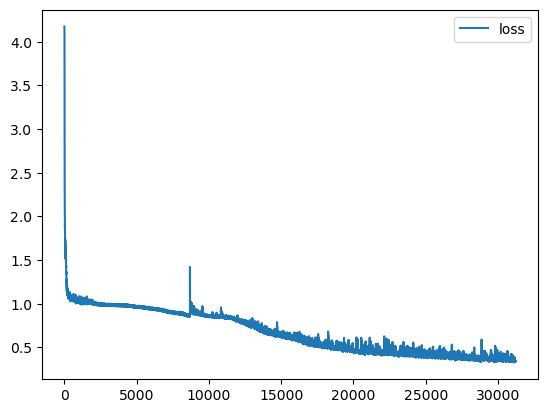

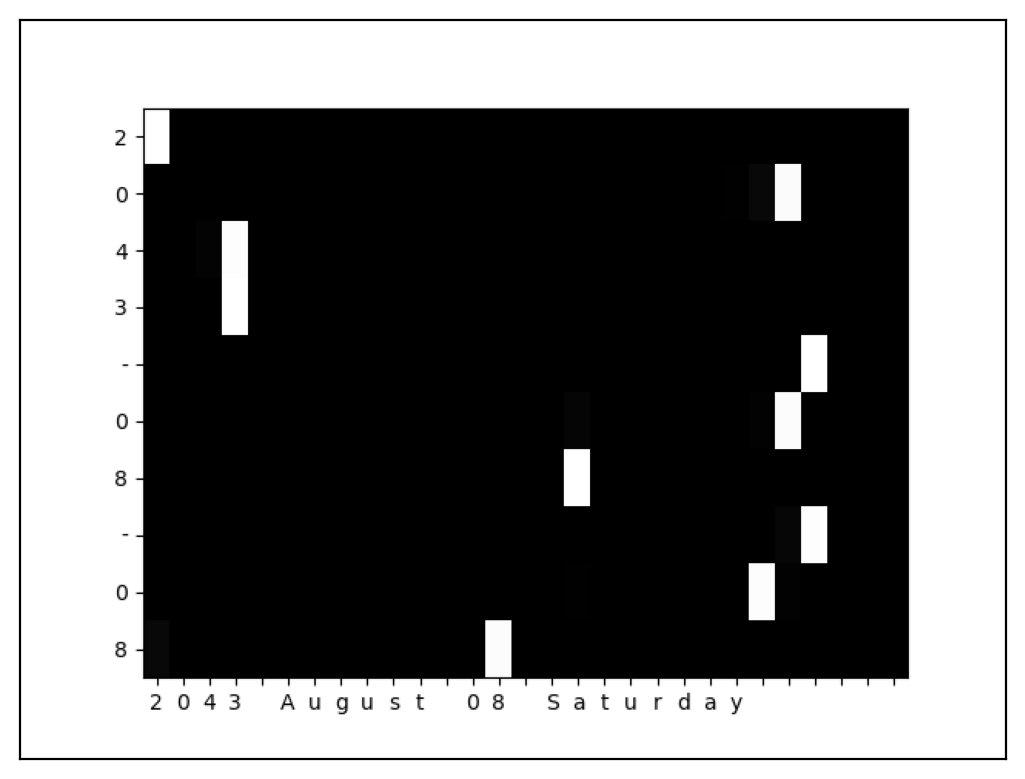

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image

plt.plot(program.losses, label='loss')
plt.legend()
plt.show()

img = Image.open('figure.png')
fig = plt.figure(dpi=200)
ax = fig.add_subplot(1, 1, 1) # (row, col, num)
ax.set_xticks([])
ax.set_yticks([])
plt.imshow(img)
plt.show()